In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import scipy as sp

The following variables are used as follows:
- `trials` Number of $q$ distributions to sample.
- `maps` Number of kernal maps $K$ to sample.
- `n` Number of values taken by the random variable $X$.
- `m` Number of values taken by the random variable $Y$.

In [12]:
trials = 100000
maps = 5
n = 3
m = 3

In [3]:
def mi(x: np.array, y_given_x: np.array) -> float:
    '''
    Computes the mutual information between random variables X, Y in the Markov Chain X -> Y.
    '''
    (n, m) = y_given_x.shape
    y_x = y_given_x * x
    y = np.sum(y_x, axis=1)
    y.shape = (-1, 1)
    return np.sum(y_x * np.log(y_x / (y.reshape((-1, 1)) * x)), axis=None)

def kl(a: np.array, b: np.array) -> float:
    '''
    Computes the kl divergence between two distributions
    '''
    return np.sum(a * np.log(a / b), axis=None)

def monotonize(arr: np.array) -> np.array:
    '''
    Given a set of data points {(x_k, y_k)}, this function returns a sequence
    of the data that is monotone in both x and y. This sequence is constructed
    following the steps:
    
    1. Sort data by x values.
    2. Remove any data point with a y value that is not increasing.
    '''
    inds = np.argsort(kls[:, 0])
    biggest = 0
    ind = 0
    mono = np.zeros_like(kls)

    for i in range(inds.shape[0]):
        if arr[inds[i], 1] >= biggest:
            biggest = arr[inds[i], 1]
            mono[ind, :] = arr[inds[i], :]
            ind = ind + 1
    
    return mono

def cc(channel: np.array) -> (float, np.array):
    '''
    Computes the chanel capacity of a kernel.
    '''
    n, m = channel.shape
    
    x = cvx.Variable(n)
    y = channel @ x
    c = np.sum(channel * np.log(channel), axis=0)
    I = c * x + cvx.sum(cvx.entr(y))
    
    objective = cvx.Maximize(I)
    constraints = [cvx.sum(x) == 1, x >= 0]
    problem = cvx.Problem(objective, constraints)
    problem.solve()
    
    if problem.status == 'optimal':
        return (problem.value, x.value)
    else:
        return (np.nan, np.nan)
    
def vi(x: np.array, y_given_x: np.array) -> float:
    return np.sum(sp.special.entr(x) + sp.special.entr(y_given_x @ x)) - 2 * mi(x, y_given_x)

The following cell tests the tightness of the bound
$$D_{KL}(pK\ \|\ qK) \leq D_{KL}(p\ \|\ q),$$
where $p, q$ are probability measures and $K$ is a Markov kernel. To do so, we fix a randomly selected $K$ and $p$. Then, a test distribution is randomly selected for $q$ and the LHS and RHS of the above equation are computed. This process is repeated for `trials` different values of $q$, and the LHS values are ploted versus the RHS.

Text(0,0.5,'D_{KL}(pK || qK)')

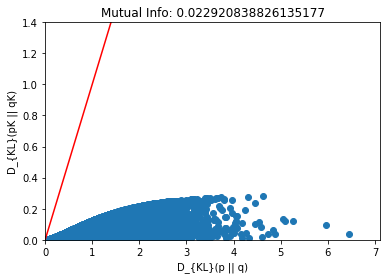

In [14]:
# np.random.seed(10)
p = np.random.rand(n)
p = p / np.sum(p)
K = np.random.rand(m, n)
K = K / np.sum(K, axis=0)
pK = K @ p

kls = np.zeros((trials, 2))

for i in range(trials):
    q = np.random.rand(n)
    q = q / np.sum(q)
    qK = K @ q

    kls[i, 0] = kl(p, q)
    kls[i, 1] = kl(pK, qK)

plt.scatter(kls[:, 0], kls[:, 1])
plt.plot([0, 5], [0, 5], '-r')
plt.title('Mutual Info: {0}'.format(mi(p, K)))
plt.ylim([0, 5 * kls[:, 1].max()])
plt.xlim([0, 1.1 * kls[:, 0].max()])
plt.xlabel('D_{KL}(p || q)')
plt.ylabel('D_{KL}(pK || qK)')

The following cells tests how the mutual information between $X$ and $Y$ in the Markov chain $X \rightarrow Y$ impacts the contractivity of the KL-divergence. This is done by repeating the previous experiment for $maps$ different values of $K$ and plotting them together, along with the mutual information computed using $p$ and the channel capacity.

In [16]:
# np.random.seed(10)

kls = np.zeros((trials, 2))
mis = np.zeros(maps)
caps = np.zeros_like(mis)
vis = np.zeros_like(mis)
mono = []

p = np.random.rand(n)
p = p / np.sum(p)

for i in range(maps):
    K = np.random.rand(m, n)
    K = K / np.sum(K, axis=0)
    pK = K @ p

    for j in range(trials):
        q = np.random.rand(n)
        q = q / np.sum(q)
        qK = K @ q

        kls[j, 0] = kl(p, q)
        kls[j, 1] = kl(pK, qK)
    
    mis[i] = mi(p, K)
    caps[i], _ = cc(K)
    vis[i] = vi(p, K)
    mono.append(monotonize(kls))

Text(0,0.5,'D_{KL}(pK || qK)')

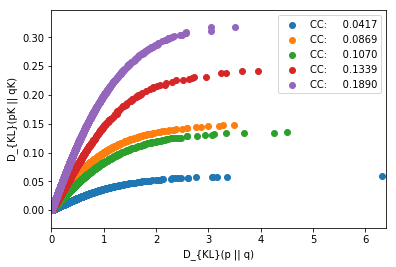

In [18]:
# plt.subplot(3, 1, 1)

# inds = np.argsort(mis)

# for i in range(len(mono)):
#     scat = plt.scatter(mono[inds[i]][:, 0], mono[inds[i]][:, 1], label='MI: {:10.4f}'.format(mis[inds[i]]))

# plt.legend()
# plt.xlim([0, 1.1 * kls[:, 0].max()])
# plt.xlabel('D_{KL}(p || q)')
# plt.ylabel('D_{KL}(pK || qK)')


#plt.subplot(2, 1, 2)
inds = np.argsort(caps)

for i in range(len(mono)):
    scat = plt.scatter(mono[inds[i]][:, 0], mono[inds[i]][:, 1], label='CC: {:10.4f}'.format(caps[inds[i]]))

#plt.plot([0, 5], [0, 5], '-r')
plt.legend(loc='best')
#plt.ylim([0, 5 * kls[:, 1].max()])
plt.xlim([0, 1.1 * kls[:, 0].max()])
plt.xlabel('D_{KL}(p || q)')
plt.ylabel('D_{KL}(pK || qK)')


# plt.subplot(2, 1, 2)
# inds = np.argsort(vis)

# for i in range(len(mono)):
#     scat = plt.scatter(mono[inds[i]][:, 0], mono[inds[i]][:, 1], label='VI: {:10.4f}'.format(vis[inds[i]]))

# #plt.plot([0, 5], [0, 5], '-r')
# plt.legend(loc='best')
# #plt.ylim([0, 5 * kls[:, 1].max()])
# plt.xlim([0, 1.1 * kls[:, 0].max()])
# plt.xlabel('D_{KL}(p || q)')
# plt.ylabel('D_{KL}(pK || qK)')

In [20]:
trials = 1000

ccs = np.zeros(trials)
eigs = np.zeros(trials)

for i in range(trials):
    K = np.random.rand(3, 3)
    K = K / np.sum(K, axis=0)
    ccs[i], _ = cc(K)
    eigs[i] = np.sort(np.abs(np.linalg.eigvals(K)))[-2]

Text(0,0.5,'2nd EV')

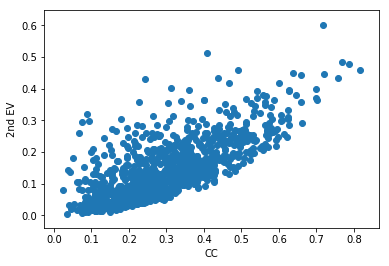

In [21]:
plt.scatter(eigs, ccs)
plt.xlabel('CC');
plt.ylabel('2nd EV')

In [6]:
z, x = cc(K.transpose())

In [7]:
y = K @ x
mi(x, K)

0.11149462596771223

In [8]:
z

0.12211226224455804

In [28]:
K

array([[0.08619724, 0.8287927 ],
       [0.91380276, 0.1712073 ]])

In [13]:
np.sort(np.array([1,3,4,-1,2]))[-2]

3